In [1]:
import sys, os
sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath("../../"))

In [3]:
from art_enrich import lib as agb
agb.detailed_enrichment_init()

In [4]:
%matplotlib inline
import numpy as np
import shutil
import betterplotlib as bpl
import sygma_utils
from scipy import interpolate
bpl.presentation_style()

In [5]:
save_dir = "/Users/gillenb/google_drive/research/agb/agb_wrapper/testing/plots/"

In [6]:
tracked_fields = ["C", "N", "O", "Fe", "Z"]
n_fields = len(tracked_fields)

In [7]:
nugrid_models = sygma_utils.make_nugrid_models(1000)

SYGMA run in progress..
   SYGMA run completed - Run time: 14.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 13.86s
SYGMA run in progress..
   SYGMA run completed - Run time: 13.84s
SYGMA run in progress..
   SYGMA run completed - Run time: 13.86s
SYGMA run in progress..
   SYGMA run completed - Run time: 14.21s


In [8]:
ages = nugrid_models[0.02].history.age

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-package

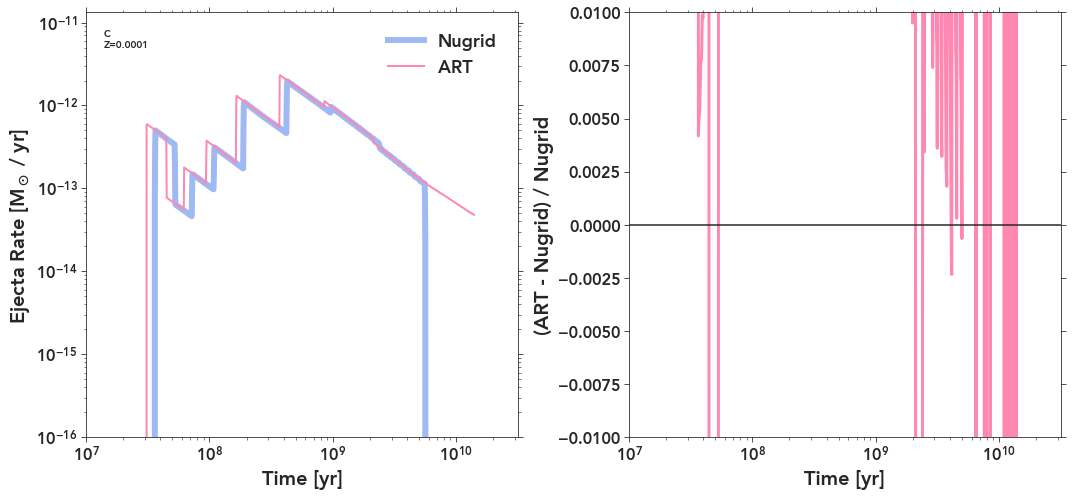

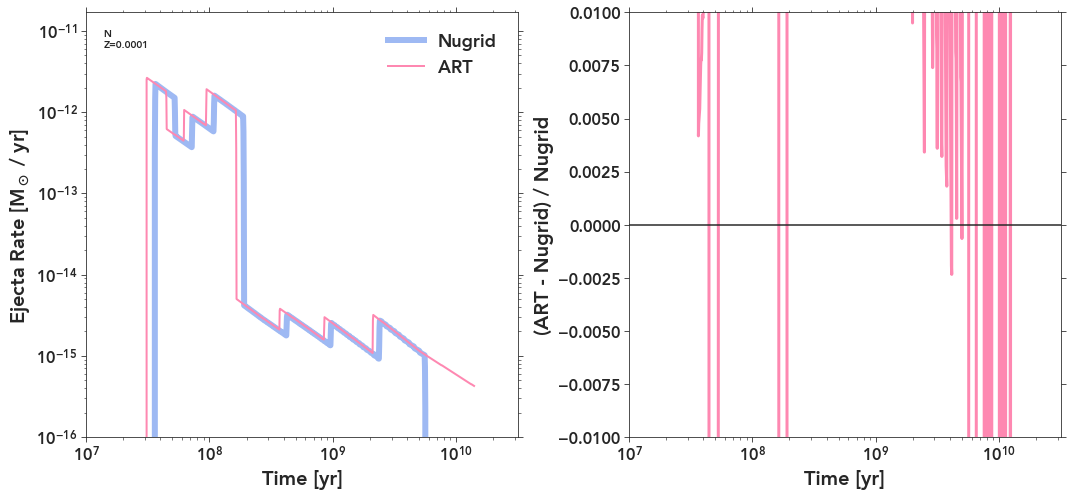

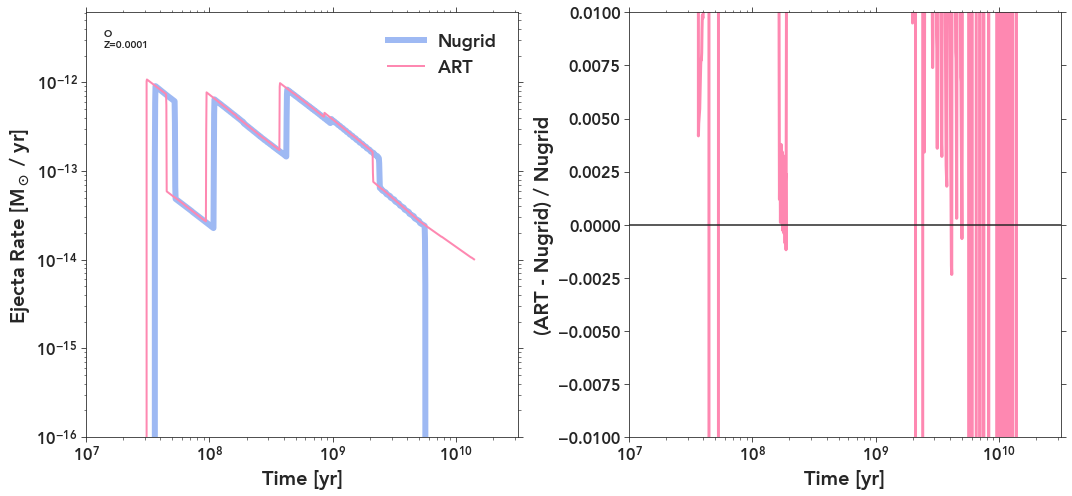

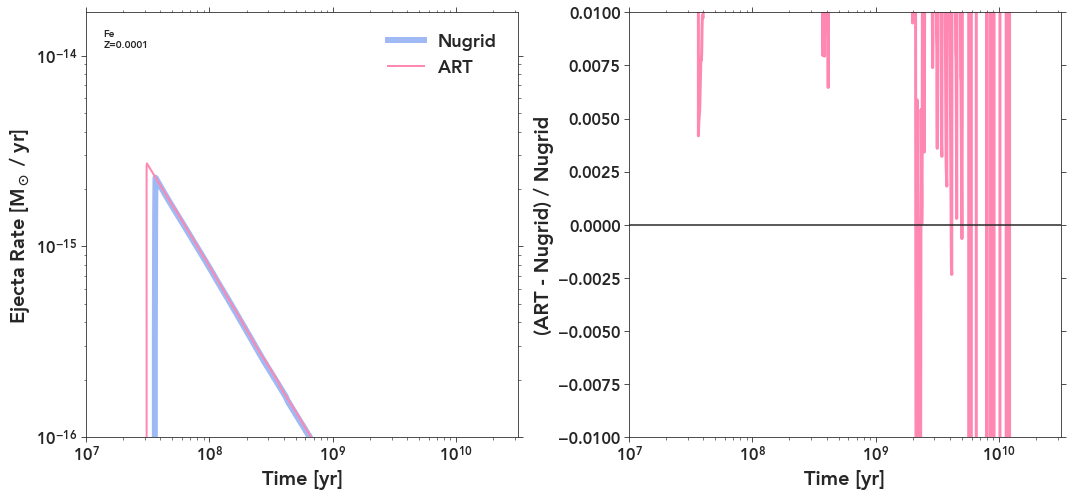

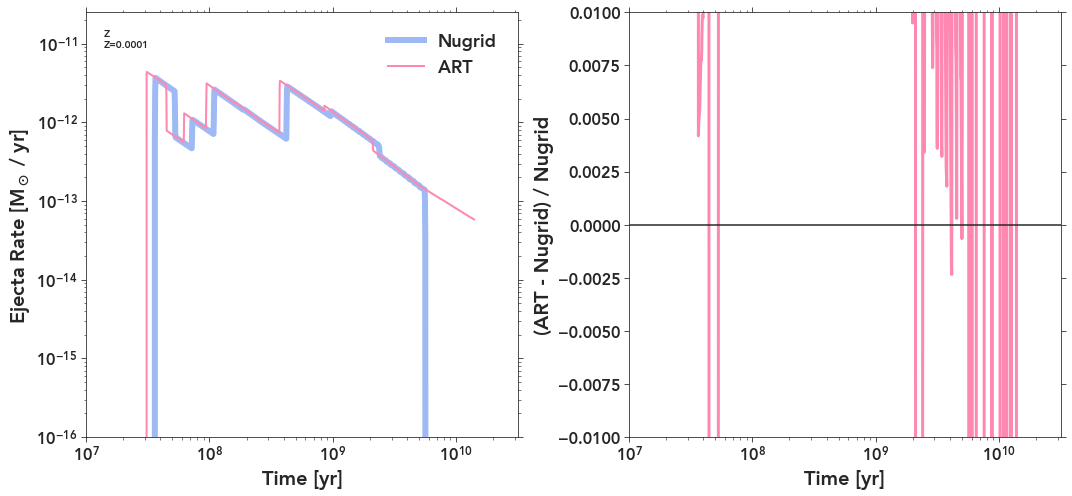

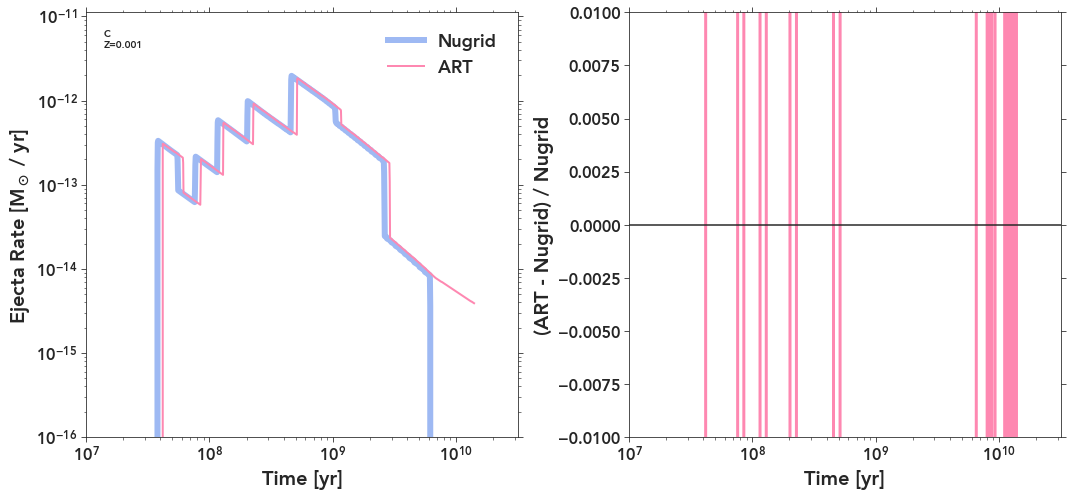

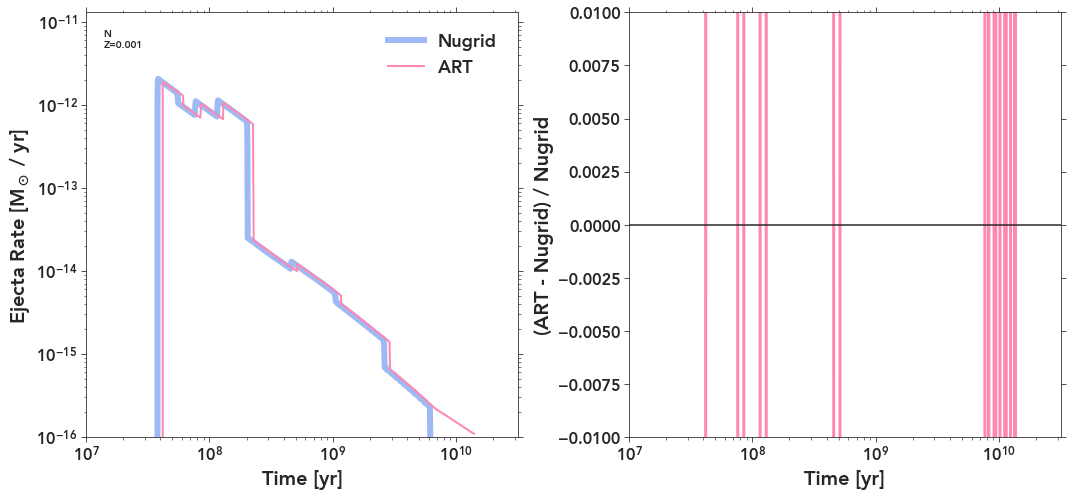

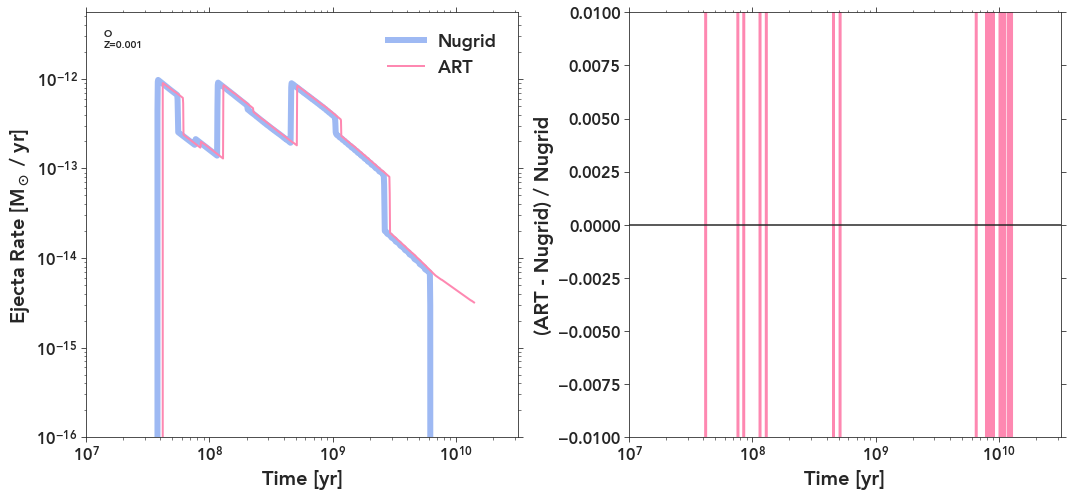

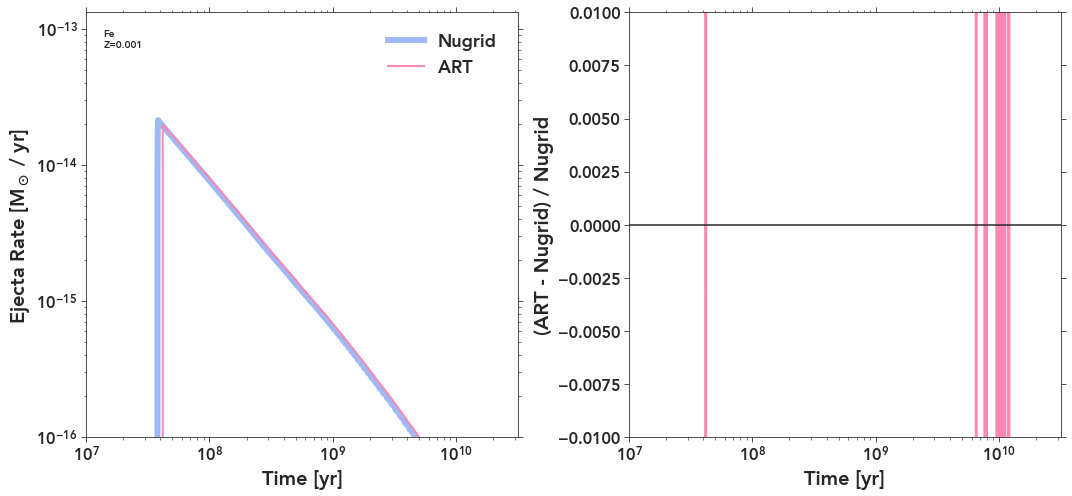

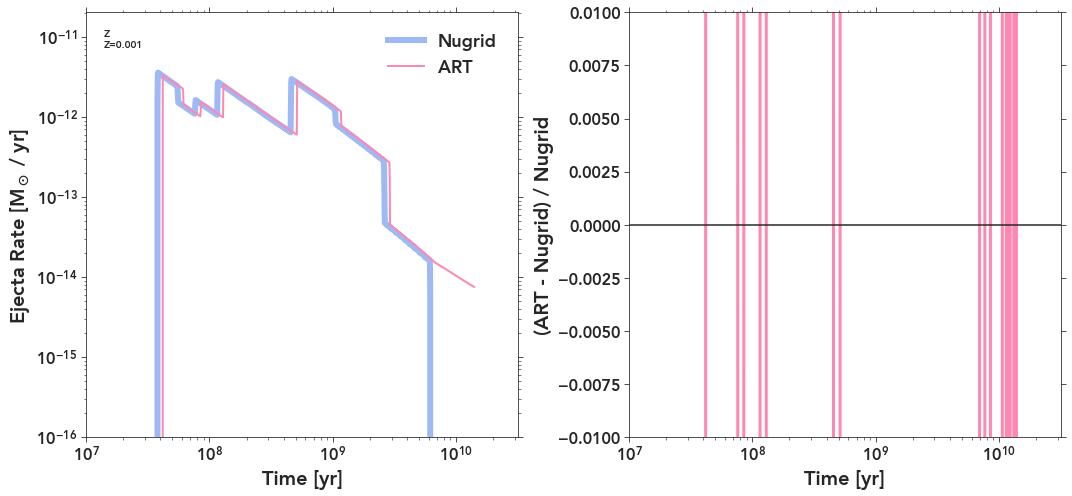

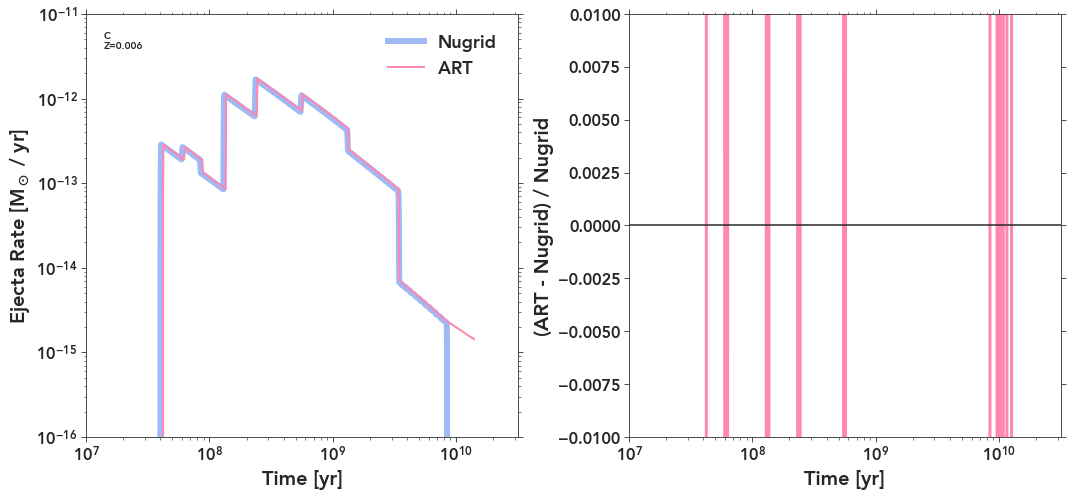

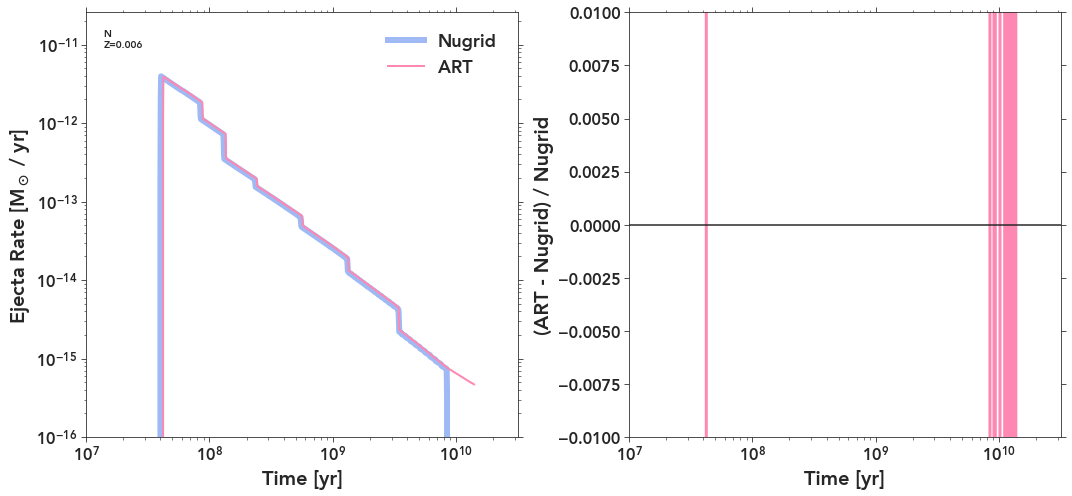

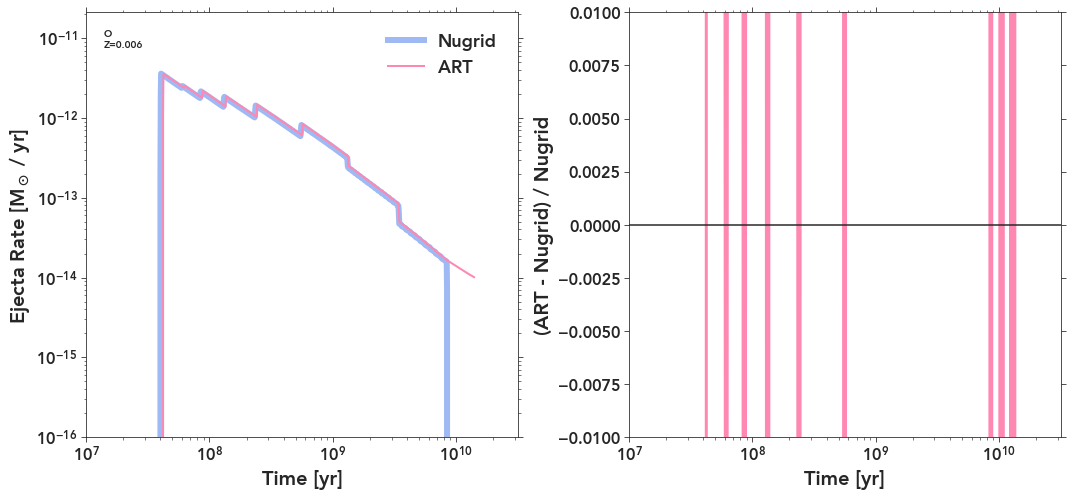

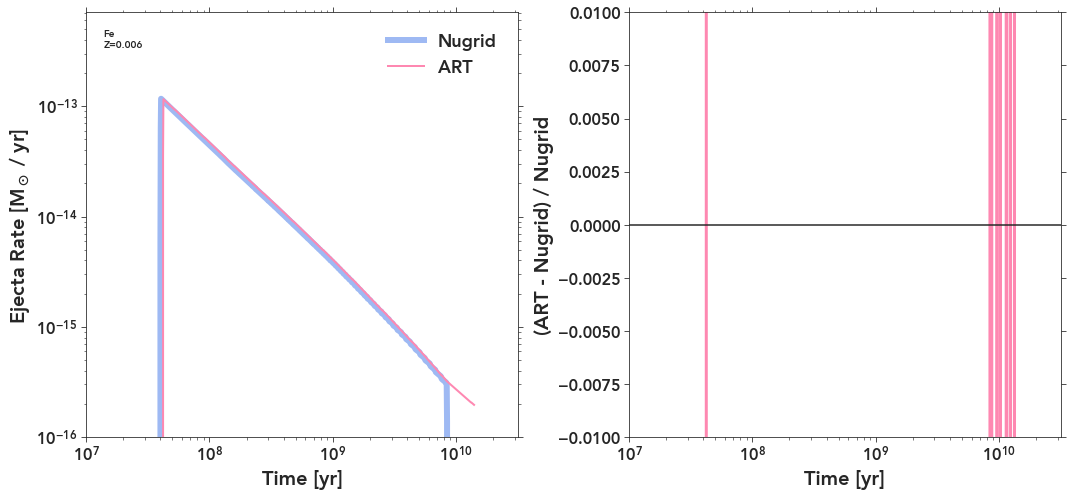

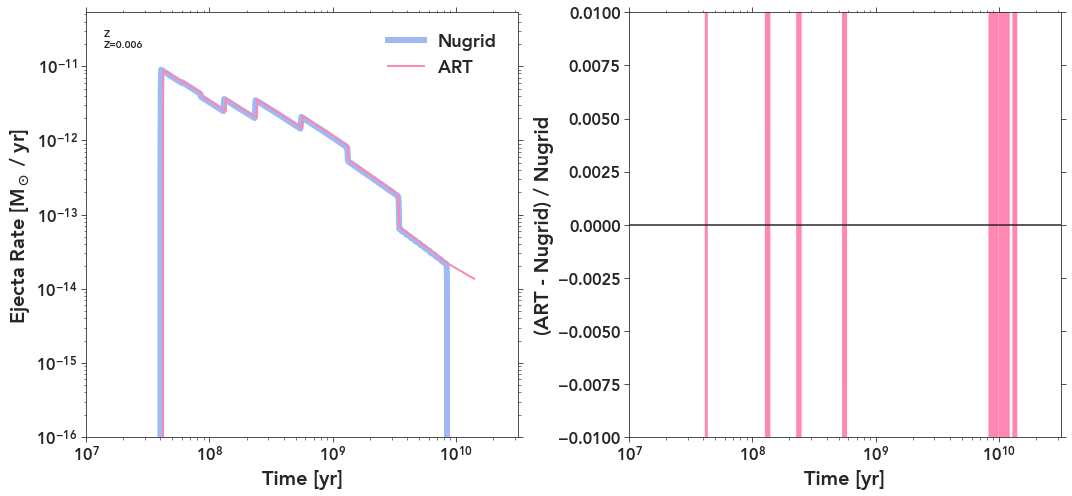

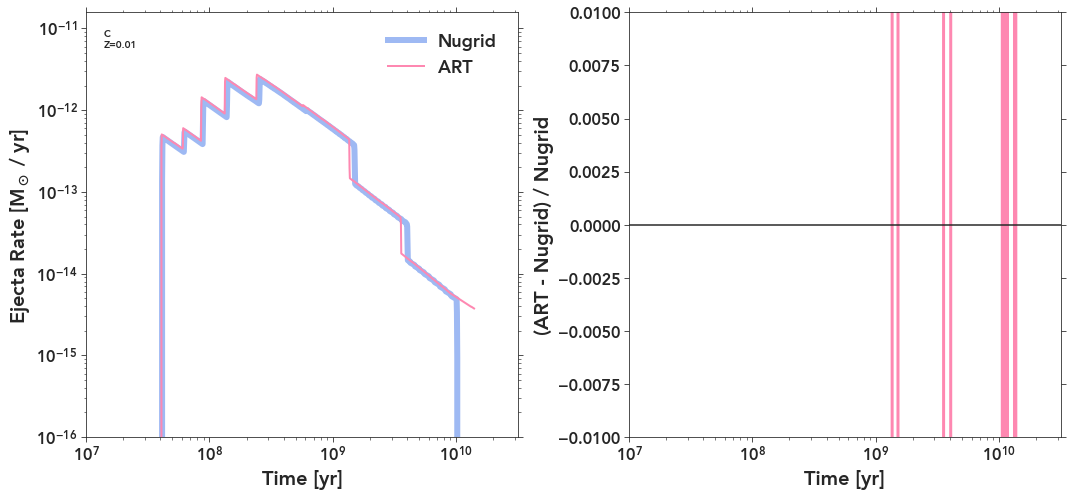

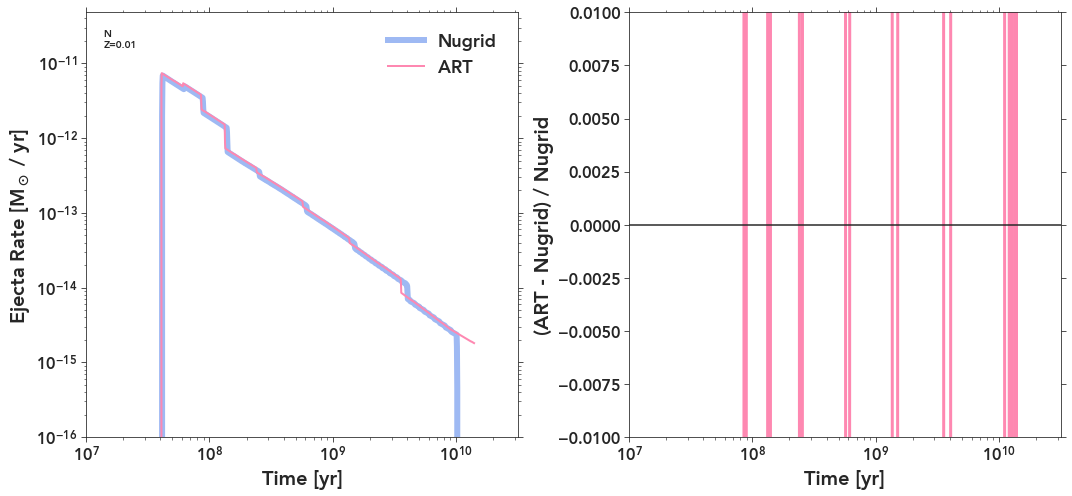

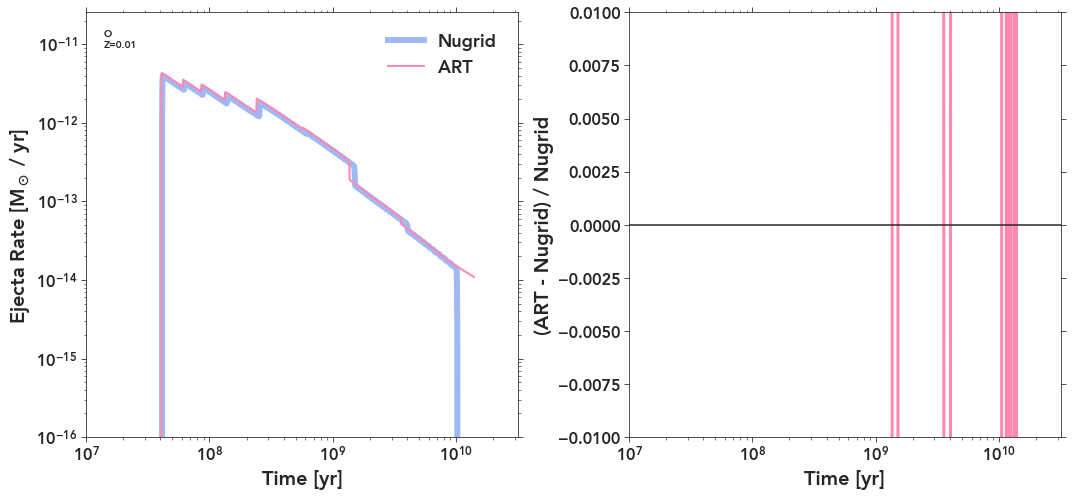

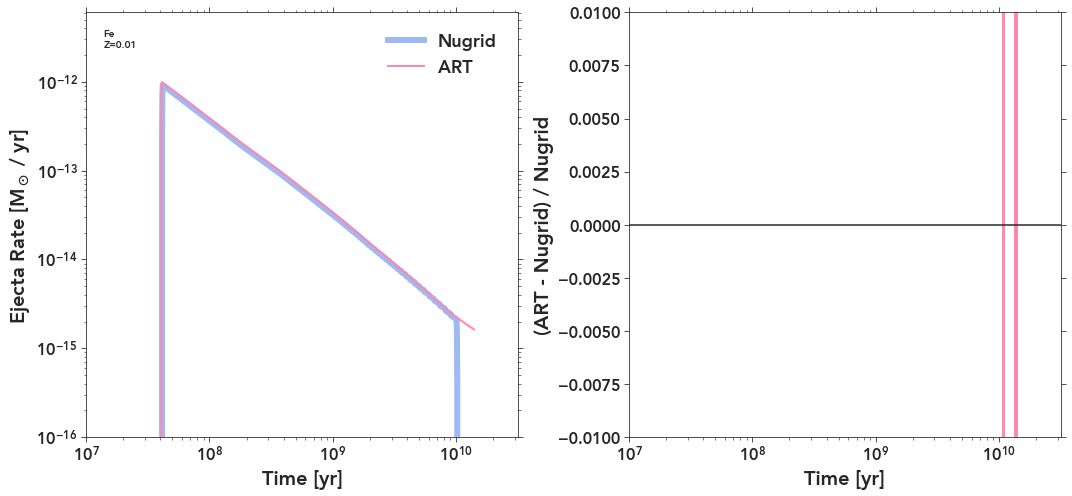

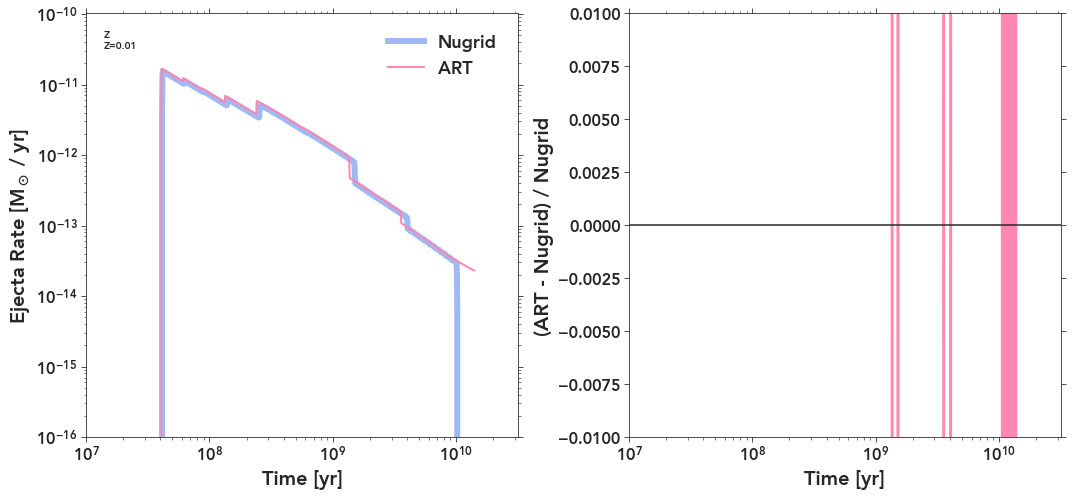

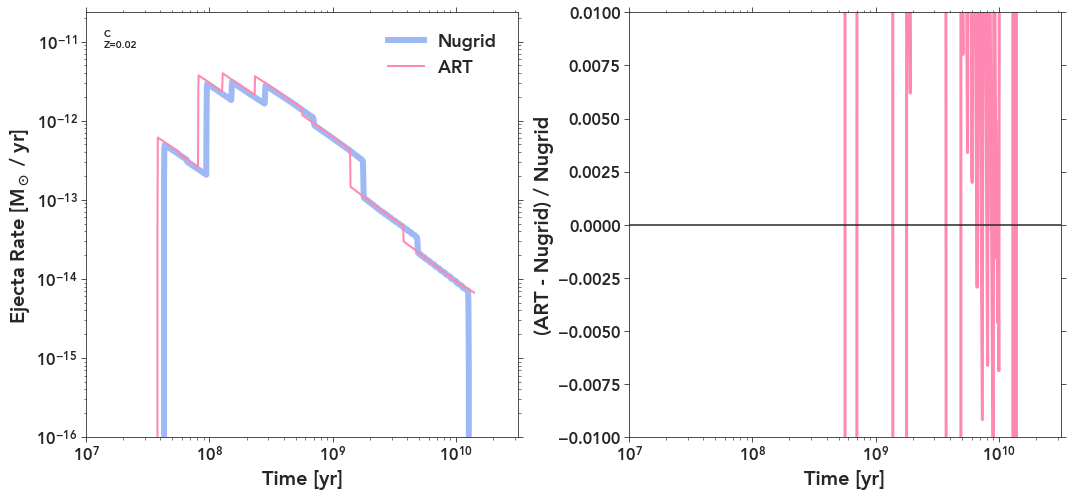

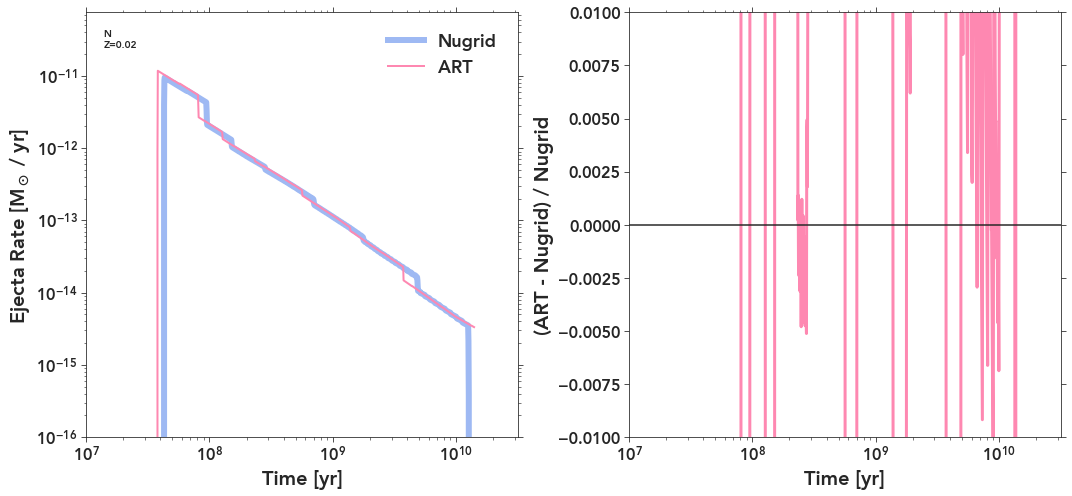

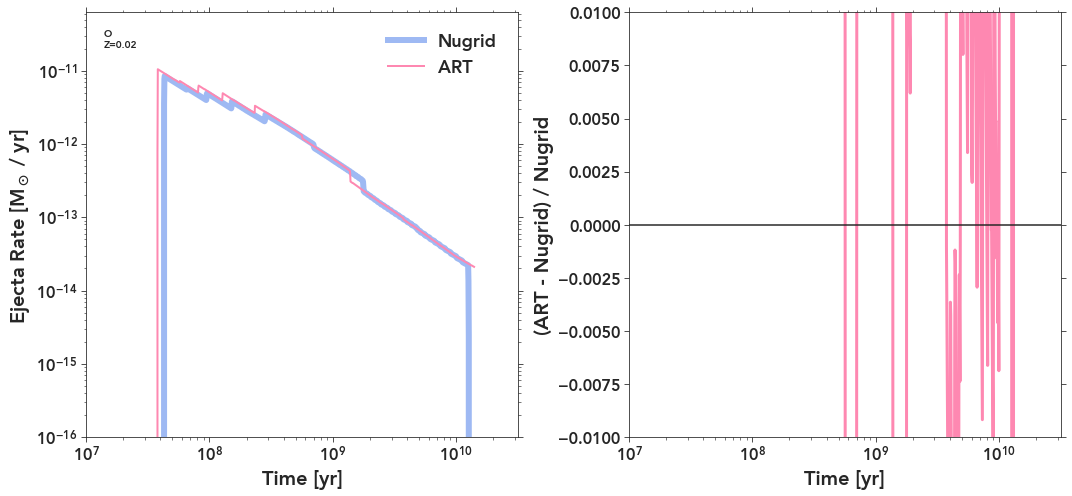

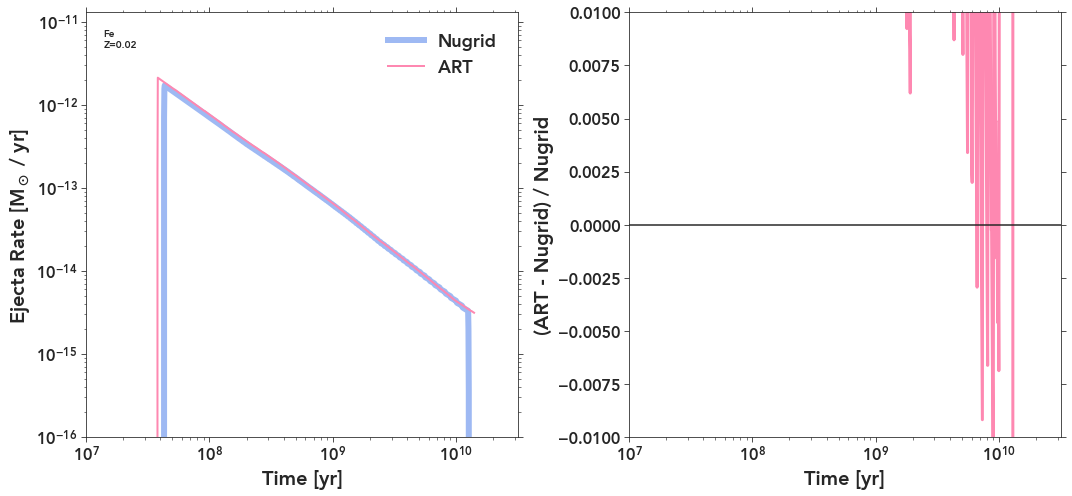

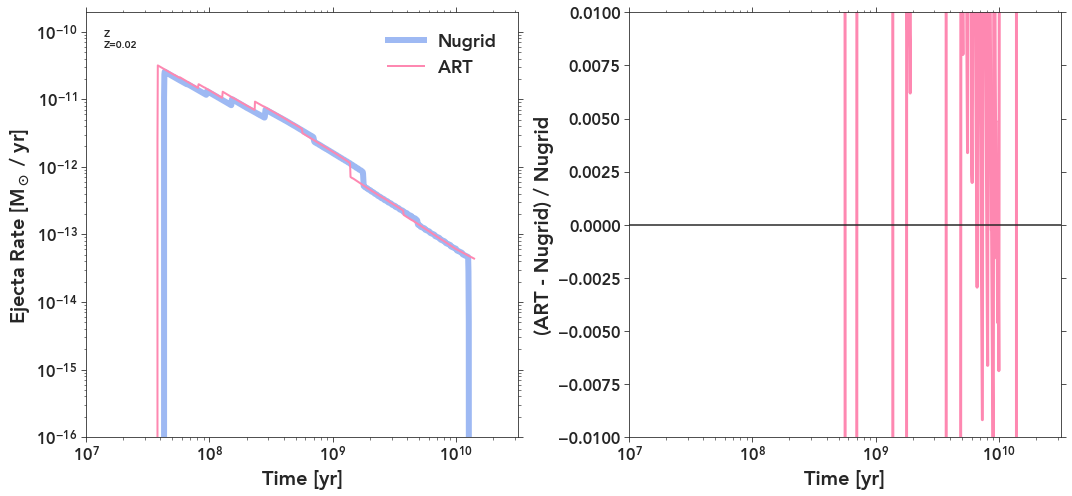

In [10]:
for z in sygma_utils.allowed_metallicities_nugrid:
    for idx, elt in enumerate(tracked_fields):
        this_ages, yields_cumulative_true = sygma_utils.get_time_resolved_yields_total(nugrid_models[z], elt, "AGB")
        yields_diff_true = sygma_utils.get_yields_diff(yields_cumulative_true, this_ages)
        
        yields_diff_art = [agb.get_ejecta_rate_agb_py(a, z)[idx] for a in ages]
        
        # plot
        fig, axs = bpl.subplots(ncols=2, figsize=[15, 7])
        ax_rate, ax_err = axs
        
        ax_rate.plot(this_ages, yields_diff_true, lw=6, zorder=4, label="Nugrid")
        ax_rate.plot(this_ages, yields_diff_art, lw=2, zorder=5, label="ART",
                     c=bpl.color_cycle[2])
        
        error = (yields_diff_art - yields_diff_true) / yields_diff_true
        ax_err.plot(this_ages, error, c=bpl.color_cycle[2])
        
        # handle the plot limits and stuff
        ax_rate.set_yscale("log")
        ax_rate.set_limits(10**7, 10**10.5, 1E-16)
        ax_rate.legend(frameon=False)

        ax_rate.add_labels("Time [yr]", "Ejecta Rate [$M_\odot$ / yr]")
        ax_rate.easy_add_text("{}\nZ={}".format(elt, z), "upper left")
        
        for ax in axs:
            ax.set_xscale("log")    
            ax.tick_params(axis="both", which="both", top=True, right=True)

        ax_err.add_labels("Time [yr]", "(ART - Nugrid) / Nugrid")
        ax_err.set_limits(10**7, 10**10.5, -0.01, 0.01)
        ax_err.axhline(0, ls="-")
        
        fig.savefig(save_dir + "rate_{}_{}.png".format(elt, z))

In [ ]:
def get_cumulative_art(dt, z, mass):
    ages = np.arange(0, 14.1E9, dt)
    total_ejecta = [[0], [0], [0], [0], [0]]
    for age in ages:
        if age == 0:
            continue
        this_ejecta = agb.get_ejecta_timestep(age, z, mass, dt)
        for field_idx in range(5):
#             print("total ejecta:", total_ejecta)
#             print("field idx:", field_idx)
#             print("this ejecta:", this_ejecta[0], this_ejecta[1], this_ejecta[2],
#                   this_ejecta[3], this_ejecta[4])
#             print("total ejecta (at idx):", this_ejecta[field_idx])
#             print("total ejecta (at idx):", total_ejecta[field_idx])
            
            next_ejecta = total_ejecta[field_idx][-1] + this_ejecta[field_idx]
#             print("next ejecta:", next_ejecta)
            total_ejecta[field_idx].append(next_ejecta)
#             print()
    return ages, total_ejecta

In [ ]:
mass = 3e4
nugrid_models_heavy = sygma_utils.make_nugrid_models(1000, mass=mass)

In [ ]:
for z in sygma_utils.allowed_metallicities_nugrid:
    for idx, elt in enumerate(tracked_fields):
        this_ages, yields_cumulative_true = sygma_utils.get_time_resolved_yields_total(nugrid_models_heavy[z], elt, "AGB")
#         yields_diff_true = sygma_utils.get_yields_diff(yields_cumulative_true, this_ages)
#         yields_cumulative_int = sygma_utils.integrate_yields_diff(yields_diff_true, this_ages)
        
#         yields_diff_art = [agb.get_ejecta_rate(a, z)[idx] for a in this_ages]
#         yields_cumulative_int_art = sygma_utils.integrate_yields_diff(yields_diff_art, this_ages)
        
        ages_art, yields_cumulative_art_all = get_cumulative_art(1E4, z, mass)
        yields_cumulative_art = yields_cumulative_art_all[idx]
        cum_art_interp = interpolate.interp1d(ages_art, yields_cumulative_art)
        yields_cumulative_art_same_grid = cum_art_interp(this_ages)
        
        # plot
        fig, axs = bpl.subplots(ncols=2, figsize=[15, 7])
        ax_rate, ax_err = axs
        
        ax_rate.plot(this_ages, yields_cumulative_true, lw=6, zorder=4, label="Nugrid")
#         ax_rate.plot(this_ages, yields_cumulative_int, lw=4, zorder=5, label="Integrated")
#         ax_rate.plot(this_ages, yields_cumulative_int_art, lw=3, zorder=6, label="Integrated ART")
        ax_rate.plot(ages_art, yields_cumulative_art, lw=2, zorder=7, label="ART",
                     c=bpl.color_cycle[2])
        
        error_art = (yields_cumulative_art_same_grid - yields_cumulative_true) / yields_cumulative_true
#         error_int = (yields_cumulative_int - yields_cumulative_true) / yields_cumulative_true
#         error_int_art = (yields_cumulative_int_art - yields_cumulative_true) / yields_cumulative_true
        
#         ax_err.plot(this_ages, error_int, lw=6, zorder=4, label="Integrated Nugrid")
#         ax_err.plot(this_ages, error_int_art, lw=4, zorder=5, label="Integrated ART")
        ax_err.plot(this_ages, error_art, label="ART", c=bpl.color_cycle[2])
        
        # handle the plot limits and stuff
        ax_rate.set_yscale("log")
        ax_rate.set_limits(10**7, 10**10.5)
        
        ax_rate.legend(frameon=False, loc=4)
#         ax_err.legend(frameon=False, loc=4)

        ax_rate.add_labels("Time [yr]", "Total Ejecta [$M_\odot$]")
        ax_rate.easy_add_text("{}\nZ={}\nM={:.1g}".format(elt, z, mass), "upper left")
        
        for ax in axs:
            ax.set_xscale("log")    
            ax.tick_params(axis="both", which="both", top=True, right=True)

        ax_err.add_labels("Time [yr]", "(ART - Nugrid) / Nugrid")
        ax_err.set_limits(10**7, 10**10.5, -0.01, 0.01)
        ax_err.axhline(0, ls="-")
        
        
        
        fig.savefig(save_dir + "cumulative_{}_{}.png".format(elt, z))